<a href="https://colab.research.google.com/github/AF332/Deep-Learning/blob/Tutorial/Gradient_Checking_N_dimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Checking

In [13]:
!pip install gcutils
from google.colab import drive
drive.mount('/content/drive')

# change the folder path with your absolute path where the folder "Tutorial - Logistic regression" is located
import sys
sys.path.append('/content/drive/MyDrive/BE41003 Tutorials/Week 3 - Tutorials Optimization and Logistic regression/Tutorial - Gradient Checking/')

# Packages
import numpy as np
from testCases import *
from gcutils import sigmoid, relu, dictionary_to_vector, vector_to_dictionary, gradients_to_vector

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ImportError: ignored

## 1) How does gradient checking work?

Backpropagation computes the gradients $\frac{\partial J}{\partial \theta}$, where $\theta$ denotes the parameters of the model. $J$ is computed using forward propagation and your loss function.

Because forward propagation is relatively easy to implement, you're confident you got that right, and so you're almost  100% sure that you're computing the cost $J$ correctly. Thus, you can use your code for computing $J$ to verify the code for computing $\frac{\partial J}{\partial \theta}$.

Let's look back at the definition of a derivative (or gradient):
$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

If you're not familiar with the "$\displaystyle \lim_{\varepsilon \to 0}$" notation, it's just a way of saying "when $\varepsilon$ is really really small."

We know the following:

- $\frac{\partial J}{\partial \theta}$ is what you want to make sure you're computing correctly.
- You can compute $J(\theta + \varepsilon)$ and $J(\theta - \varepsilon)$ (in the case that $\theta$ is a real number), since you're confident your implementation for $J$ is correct.

Lets use equation (1) and a small value for $\varepsilon$ to convince your CEO that your code for computing  $\frac{\partial J}{\partial \theta}$ is correct!

## 3) N-dimensional gradient checking

The following figure describes the forward and backward propagation of your fraud detection model.

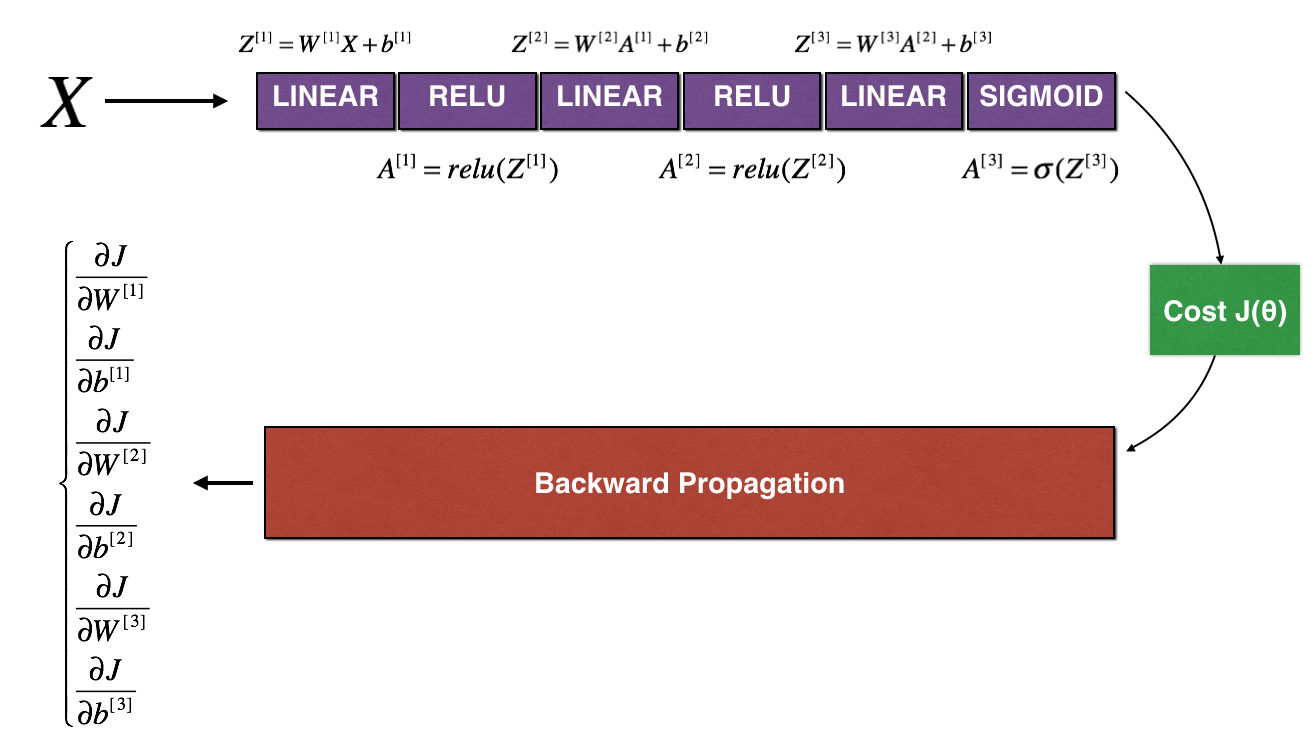
<caption><center> <u> **Figure 2** </u>: **deep neural network**<br>*LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID*</center></caption>

Let's look at your implementations for forward propagation and backward propagation.

In [3]:
def forward_propagation_n(X, Y, parameters):
    """
    Implements the forward propagation (and computes the cost) presented in Figure 3.

    Arguments:
    X -- training set for m examples
    Y -- labels for m examples
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (5, 4)
                    b1 -- bias vector of shape (5, 1)
                    W2 -- weight matrix of shape (3, 5)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)

    Returns:
    cost -- the cost function (logistic cost for one example)
    """

    # retrieve parameters
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # Cost
    logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    cost = 1./m * np.sum(logprobs)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return cost, cache

Now, run backward propagation.

In [ ]:
def backward_propagation_n(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.

    Arguments:
    X -- input datapoint, of shape (input size, 1)
    Y -- true "label"
    cache -- cache output from forward_propagation_n()

    Returns:
    gradients -- A dictionary with the gradients of the cost with respect to each parameter, activation and pre-activation variables.
    """

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

You obtained some results on the fraud detection test set but you are not 100% sure of your model. Nobody's perfect! Let's implement gradient checking to verify if your gradients are correct.

**How does gradient checking work?**.

As in 1) and 2), you want to compare "gradapprox" to the gradient computed by backpropagation. The formula is still:

$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

However, $\theta$ is not a scalar anymore. It is a dictionary called "parameters". We implemented a function "`dictionary_to_vector()`" for you. It converts the "parameters" dictionary into a vector called "values", obtained by reshaping all parameters (W1, b1, W2, b2, W3, b3) into vectors and concatenating them.

The inverse function is "`vector_to_dictionary`" which outputs back the "parameters" dictionary.

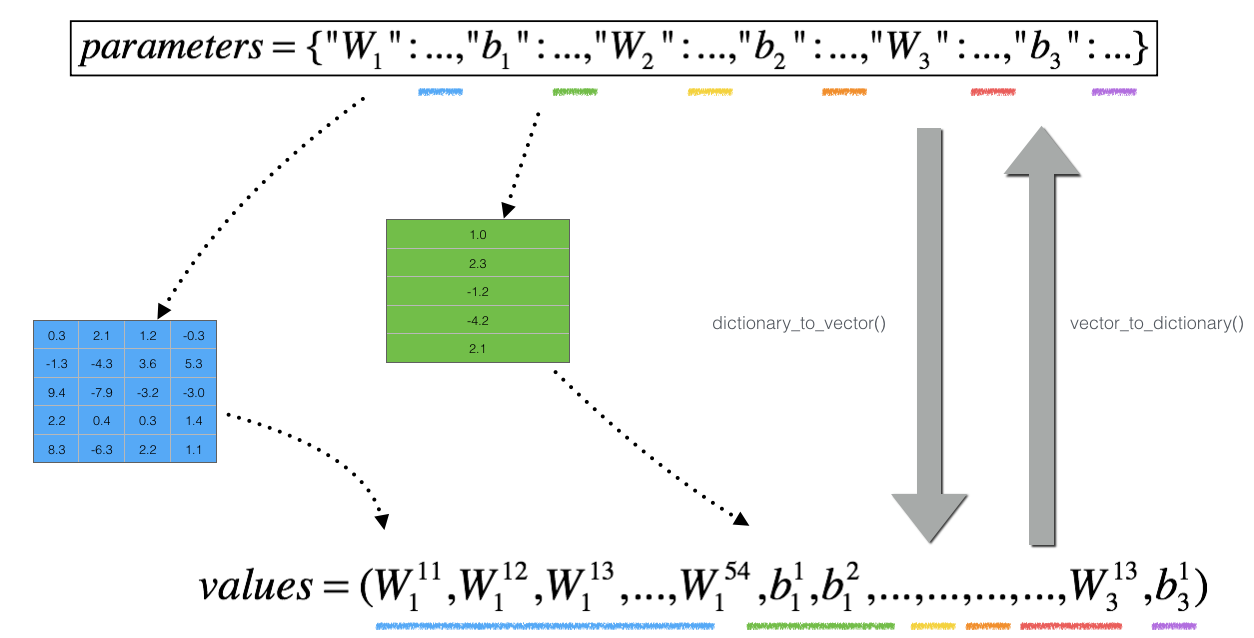
<caption><center> <u> **Figure 2** </u>: **dictionary_to_vector() and vector_to_dictionary()**<br> You will need these functions in gradient_check_n()</center></caption>

We have also converted the "gradients" dictionary into a vector "grad" using gradients_to_vector(). You don't need to worry about that.

**Exercise**: Implement gradient_check_n().

**Instructions**: Here is pseudo-code that will help you implement the gradient check.

For each i in num_parameters:
- To compute `J_plus[i]`:
    1. Set $\theta^{+}$ to `np.copy(parameters_values)`
    2. Set $\theta^{+}_i$ to $\theta^{+}_i + \varepsilon$
    3. Calculate $J^{+}_i$ using to `forward_propagation_n(x, y, vector_to_dictionary(`$\theta^{+}$ `))`.     
- To compute `J_minus[i]`: do the same thing with $\theta^{-}$
- Compute $gradapprox[i] = \frac{J^{+}_i - J^{-}_i}{2 \varepsilon}$

Thus, you get a vector gradapprox, where gradapprox[i] is an approximation of the gradient with respect to `parameter_values[i]`. You can now compare this gradapprox vector to the gradients vector from backpropagation. Just like for the 1D case (Steps 1', 2', 3'), compute:
$$ difference = \frac {\| grad - gradapprox \|_2}{\| grad \|_2 + \| gradapprox \|_2 } \tag{3}$$

In [ ]:
# FUNCTION: gradient_check_n

def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n

    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters.
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)

    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """

    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))

    # Compute gradapprox
    for i in range(num_parameters):

        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        ### START CODE HERE ### (approx. 3 lines)
        thetaplus = np.copy(parameters_values)                                       # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                  # Step 2
        J_plus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(thetaplus))  # Step 3
        ### END CODE HERE ###

        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        ### START CODE HERE ### (approx. 3 lines)
        thetaminus = np.copy(parameters_values)                                       # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                                 # Step 2
        J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(thetaminus)) # Step 3
        ### END CODE HERE ###

        # Compute gradapprox[i]
        ### START CODE HERE ### (approx. 1 line)
        gradapprox[i] = (J_plus[i] - J_minus[i])/(2*epsilon)
        ### END CODE HERE ###

    # Compare gradapprox to backward propagation gradients by computing difference.
    ### START CODE HERE ### (approx. 1 line)
    numerator = np.linalg.norm(grad - gradapprox)                       # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)     # Step 2'
    difference = numerator/denominator                                  # Step 3'
    ### END CODE HERE ###

    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

    return difference

In [ ]:
X, Y, parameters = gradient_check_n_test_case()

cost, cache = forward_propagation_n(X, Y, parameters)
gradients = backward_propagation_n(X, Y, cache)
difference = gradient_check_n(parameters, gradients, X, Y)

Your backward propagation works perfectly fine! difference = 1.1890913023330276e-07


**Expected output**:

<table>
    <tr>
        <td>  ** There is a mistake in the backward propagation!**  </td>
        <td> difference = 0.285093156781 </td>
    </tr>
</table>

It seems that there were errors in the `backward_propagation_n` code I gave you! Good that you've implemented the gradient check. Go back to `backward_propagation` and try to find/correct the errors *(Hint: check dW2 and db1)*. Rerun the gradient check when you think you've fixed it. Remember you'll need to re-execute the cell defining `backward_propagation_n()` if you modify the code.

**Note**
- Gradient Checking is slow! Approximating the gradient with $\frac{\partial J}{\partial \theta} \approx  \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon}$ is computationally costly. For this reason, we don't run gradient checking at every iteration during training. Just a few times to check if the gradient is correct.
- Gradient Checking, at least as we've presented it, doesn't work with dropout. You would usually run the gradient check algorithm without dropout to make sure your backprop is correct, then add dropout.

<font color='blue'>
**What you should remember from this notebook**:
- Gradient checking verifies closeness between the gradients from backpropagation and the numerical approximation of the gradient (computed using forward propagation).
- Gradient checking is slow, so we don't run it in every iteration of training. You would usually run it only to make sure your code is correct, then turn it off and use backprop for the actual learning process.